**概要**  
- LightGBM
- カテゴリカル変数の処理なし
- 欠損値処理なし

In [2]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# データの読み込み
# INPUT_DIRにディレクトリを指定
INPUT_DIR = "xxx"

df_train = pd.read_csv(INPUT_DIR + "train.csv")
df_test = pd.read_csv(INPUT_DIR + "test.csv")
data_dic = pd.read_csv(INPUT_DIR + "data_dictionary.csv")# 辞書データ
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
df_train.head(20)

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223
5,5,High,No,Poor,Yes,2.0,7.0,TBI + Cy +- Other,No,4.0,...,Permissive mismatched,Related,"N/A, Mel not given",5.0,No,2.0,Yes,6.0,1.0,7.095
6,6,Low,No,Poor,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,0.0,46.464
7,7,High,No,NaN,Not done,2.0,5.0,TBI + Cy +- Other,No,3.0,...,NaN,Related,"N/A, Mel not given",5.0,No,1.0,No,6.0,0.0,18.076
8,8,Intermediate,No,Other,No,NaN,NaN,TBI + Cy +- Other,No,6.0,...,NaN,Related,"N/A, Mel not given",8.0,No,NaN,Yes,10.0,1.0,10.130
9,9,Intermediate,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,9.0,1.0,5.434


In [4]:
df_train.isnull().sum()

ID                            0
dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
hla_match_c_high           4620
hla_high_res_8             5829
tbi_status                    0
arrhythmia                 2202
hla_low_res_6              3270
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
hla_high_res_6             5284
cmv_status                  634
hla_high_res_10            7163
hla_match_dqb1_high        5199
tce_imm_match             11133
hla_nmdp_6                 4197
hla_match_c_low            2800
rituximab                  2148
hla_match_drb1_low         2643
hla_match_dqb1_low         4194
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
year_hct                      0
obesity                    1760
mrd_hct 

**ノートブックを参考にしてみる**  
参考：https://www.kaggle.com/code/samanfatima7/cibmtr-bridging-gaps-in-survival

In [5]:
import lifelines
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lifelines import KaplanMeierFitter
from sklearn.metrics import mean_squared_error
import warnings

**生存関数に関して**  
- Kaplan-Meier推定量を用いた生存関数の推定  
    - 「生存期間」と「生存フラグ」から『特定の期間における生存確率』を算出
    - 今回はこの『生存確率』が目的変数
- 参考：https://qiita.com/roki18d/items/3d725333ff1616a8977c

In [6]:
# 生存確率を計算する関数
# efs：無イベント生存率
# efs_time：無イベント生存までの時間
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter() # インスタンスを作成
    kmf.fit(df[time_col], event_observed=df[event_col]) # カプラン・マイヤー推定量にデータをフィット
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    censored_mask = df[event_col] == 0
    return survival_probabilities

In [7]:
# 生存確率を目的変数として代入
df_train["target"] = transform_survival_probability(df_train, time_col='efs_time', event_col='efs')
df_train.head(  )

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,target
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,0.458687
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,0.847759
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,0.462424
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,0.456661
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,0.464674


In [8]:
# 不要になったカラムを削除
drop_cols = ["ID", 'efs', 'efs_time']
df_train = df_train.drop(columns=[col for col in drop_cols if col in df_train.columns])
df_test = df_test.drop(columns=[col for col in drop_cols if col in df_test.columns])  # "df_test"には'efs'と'efs_time'はない
df_train.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,target
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,...,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.458687
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,...,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,0.847759
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.462424
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.456661
4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.464674


**データ型処理**

In [9]:
# ojbect型をcategory型に変換
def convert_object_to_category(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

df_train = convert_object_to_category(df_train)
df_test = convert_object_to_category(df_test)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   dri_score               28646 non-null  category
 1   psych_disturb           26738 non-null  category
 2   cyto_score              20732 non-null  category
 3   diabetes                26681 non-null  category
 4   hla_match_c_high        24180 non-null  float64 
 5   hla_high_res_8          22971 non-null  float64 
 6   tbi_status              28800 non-null  category
 7   arrhythmia              26598 non-null  category
 8   hla_low_res_6           25530 non-null  float64 
 9   graft_type              28800 non-null  category
 10  vent_hist               28541 non-null  category
 11  renal_issue             26885 non-null  category
 12  pulm_severe             26665 non-null  category
 13  prim_disease_hct        28800 non-null  category
 14  hla_high_res_6        

**カテゴリ変数の処理**  
- 一旦無視する
- 特徴量を見て適切な処理を行うのがよさそう
    - https://tebasakisan.hatenadiary.com/entry/2019/01/27/222102

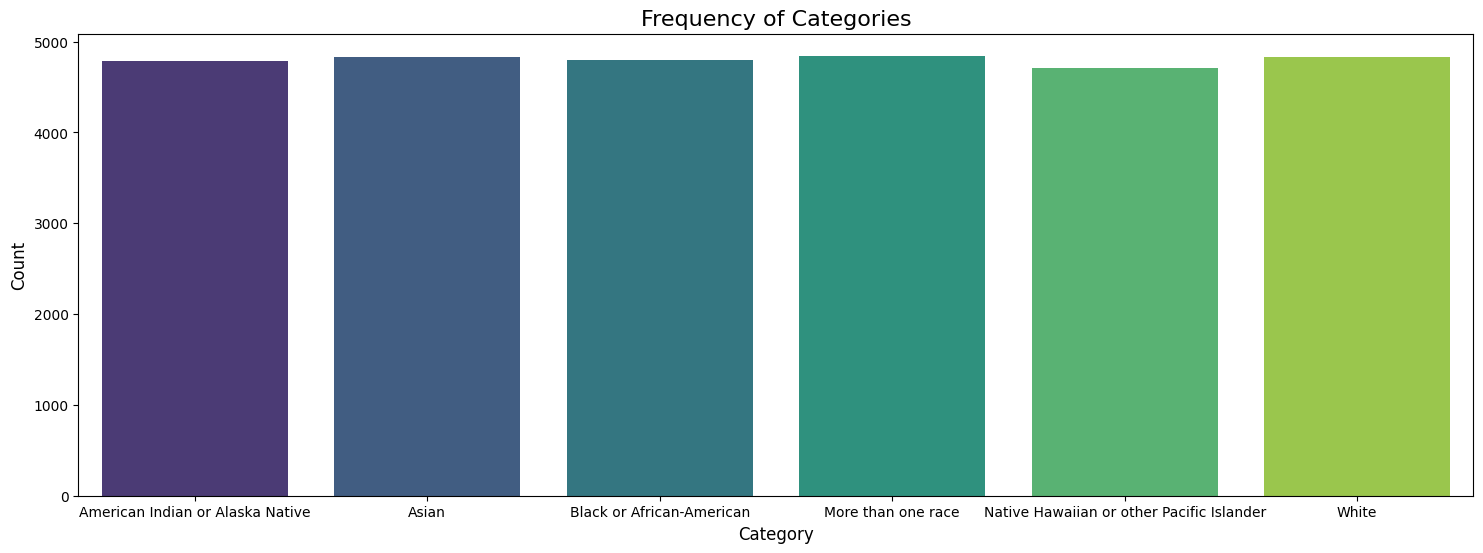

In [10]:
# 人種ごとの出現数
race_counts = df_train['race_group'].value_counts()

# 可視化
plt.figure(figsize=(18, 6))
sns.barplot(x=race_counts.index, y=race_counts.values, palette="viridis")
plt.title("Frequency of Categories", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**欠損値補完**  
- 同様に一旦無視するが，後で処理する
    - https://tebasakisan.hatenadiary.com/entry/2019/01/27/222102

**モデル構築**  
- LightGBM
    - インポート：https://qiita.com/ryo_hagi/items/343d23904cad570b03b5
    - ハイパラチューニング：https://qiita.com/c60evaporator/items/351188110f328ff921b9
        - 今回は実施できていない
    - 種類と使い方：https://lee-ann-al-chan.com/wp/wp-login.php/2022/10/03/lightgbm_trainingapi_sclearnapi/
        - Training API
            - 今回はこっちを使ってみる
        - Scikit-learn API
- C統計量について
    - 理論上AUCと同じ値
    - 参考：https://note.com/yohei_okada/n/nd384bd62c6d5

In [11]:
# Stratified C-indexの算出
def stratified_c_index(y_true, y_pred, groups):
    unique_groups = np.unique(groups)
    c_indices = []

    for group in unique_groups:
        mask = groups == group
        if sum(mask) > 1:  
            y_true_group = y_true[mask]
            y_pred_group = y_pred[mask]
            concordant = 0
            permissible = 0

            for i in range(len(y_true_group)):
                for j in range(i + 1, len(y_true_group)):
                    if y_true_group[i] != y_true_group[j]:
                        permissible += 1
                        if (y_pred_group[i] > y_pred_group[j] and y_true_group[i] > y_true_group[j]) or \
                           (y_pred_group[i] < y_pred_group[j] and y_true_group[i] < y_true_group[j]):
                            concordant += 1

            c_indices.append(concordant / permissible if permissible > 0 else 0)

    c_indices = np.array(c_indices)
    return np.mean(c_indices) - np.std(c_indices)

In [12]:
# データの準備
X = df_train.drop(columns=['target'], axis=1)
y = df_train['target']
race_groups = df_train['race_group']  # 層別に利用

In [13]:
# ライブラリのインストール
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

In [14]:
# カテゴリカル変数の列を取得
cat_features = list(X.select_dtypes(include=['category']).columns)
cat_features

['dri_score',
 'psych_disturb',
 'cyto_score',
 'diabetes',
 'tbi_status',
 'arrhythmia',
 'graft_type',
 'vent_hist',
 'renal_issue',
 'pulm_severe',
 'prim_disease_hct',
 'cmv_status',
 'tce_imm_match',
 'rituximab',
 'prod_type',
 'cyto_score_detail',
 'conditioning_intensity',
 'ethnicity',
 'obesity',
 'mrd_hct',
 'in_vivo_tcd',
 'tce_match',
 'hepatic_severe',
 'prior_tumor',
 'peptic_ulcer',
 'gvhd_proph',
 'rheum_issue',
 'sex_match',
 'race_group',
 'hepatic_mild',
 'tce_div_match',
 'donor_related',
 'melphalan_dose',
 'cardiac',
 'pulm_moderate']

In [25]:
# K分割交差検証
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_predictions = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, race_groups)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    race_val = race_groups.iloc[val_idx]

    # LightGBM用データセット作成
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)

    # モデルのハイパーパラメータ
    params = {
        'task':'train',
        'objective': 'regression', # 回帰
        'boosting':'gbdt', # 'gbdt'はGradient Boosting Decision TreeによるBoosting 
        'metric': 'rmse', # C統計量と数学的に同じ値のため(https://note.com/yohei_okada/n/nd384bd62c6d5)
        'num_leaves': 64, # 決定木の最大葉ノード数（大きすぎると過学習）
        'max_depth': 7, # 決定木の深さ
        'min_data_in_leaf': 20, # それぞれの葉ノードに必要なデータ数（過学習の防止）
        'lambda_l2': 3, # L2正則化の強さを指定（大きいほど強く過学習が少なくなる）
        'random_state': 42, # 乱数シード．再現性の確保
        'verbose': 1, # 学習過程の表示レベル
    }

    # モデルの訓練
    model = lgb.train(
        params, # ハイパーパラメータ
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        # early_stopping_rounds=50, # 検証スコアが改善されないラウンド数
        callbacks=[lgb.early_stopping(stopping_rounds=50)],  # コールバックで早期終了を設定（early_stopping_roundだとエラーが出たため）
        # verbose_eval=100, # 100回ごとに学習結果を表示
        num_boost_round=1000, # 学習ラウンド数
    )

    # 予測と評価
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    fold_score = stratified_c_index(y_val.values, y_val_pred, race_val.values)
    print(f"Stratified C-Index for Fold {fold + 1}: {fold_score}")

    final_predictions[val_idx] = y_val_pred

# Overall Stratified Concordance Index
overall_score = stratified_c_index(y.values, final_predictions, race_groups.values)
print(f"Overall Stratified C-Index: {overall_score}")


Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 23040, number of used features: 57
[LightGBM] [Info] Start training from score 0.606081
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [26]:
pred = model.predict(df_test)
print(pred)

[0.59582162 0.60029585 0.59582162]


**提出**

In [ ]:
# 提出用ファイルに代入
sample_sub['prediction'] = pred
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()